In [1]:
#imports
import requests
import yfinance as yf
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from torch.autograd import Variable
import dateutil
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Get the tickers of the companies in the Stock and Poor's Top 500

In [2]:
LIST_OF_COMPANIES_WIKI = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
website_url = requests.get(LIST_OF_COMPANIES_WIKI).text
soup = BeautifulSoup(website_url, "html.parser")
my_table = soup.find('table',{'class':'wikitable sortable', 'id': "constituents"})
label_items = my_table.findAll('a', {'class': 'external text', 'rel': 'nofollow'})
labels = []
for label_item in label_items:
    label = label_item.get_text()
    if label == 'reports' or label == 'Aptiv Plc':
        continue
    labels.append(label)
print(labels)

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES', 'AMG', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN', 'ALGN', 'ALLE', 'AGN', 'ADS', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'AIV', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ARNC', 'ANET', 'AJG', 'AIZ', 'ATO', 'T', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BKR', 'BLL', 'BAC', 'BK', 'BAX', 'BBT', 'BDX', 'BRK.B', 'BBY', 'BIIB', 'BLK', 'HRB', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BF.B', 'CHRW', 'COG', 'CDNS', 'CPB', 'COF', 'CPRI', 'CAH', 'KMX', 'CCL', 'CAT', 'CBOE', 'CBRE', 'CBS', 'CDW', 'CE', 'CELG', 'CNC', 'CNP', 'CTL', 'CERN', 'CF', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'XEC', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'CXO', 'COP', 'ED', 'STZ', 'COO', 'CPRT', 'GLW', 'CTVA', 'COST', 'CO

The model attributes are as follows: 
It takes in 60 days of prior stock information, currently only the opening prices. 
It has a double stacked LSTM layer with 64 hidden features, no batching, and no dropout.
The output from the first LSTM is fed to the input to the second LSTM. The last layer is a Linear layer

In [3]:
# Globals
INPUT_SIZE = 60
HIDDEN_SIZE = 64
NUM_LAYERS = 2
OUTPUT_SIZE = 1

# Hyper parameters

learning_rate = 0.001
num_epochs = 100

In [4]:
# Importing the data set
ticker = yf.Ticker(labels[0])
data_set = ticker.history(period="max")
data_set = data_set[data_set.index>dateutil.parser.parse("2009-06-01")]
data_set = data_set.drop(['Dividends', 'Stock Splits', 'High', 'Low', 'Close','Volume'], axis = 1)
train_set, test_set = train_test_split(data_set, test_size=0.2, train_size=0.8, shuffle=False)
sc = MinMaxScaler(feature_range = (0, 1))
train_fit = sc.fit(train_set)
train_scaled = sc.transform(train_set)
print(train_set.shape)
print(test_set.shape)

(2106, 1)
(527, 1)


In [5]:
# Creating a data structure with 60 timesteps and 1 output
x_train = []
y_train = []
for i in range(INPUT_SIZE, train_scaled.shape[0]):
    x_train.append(train_scaled[i-INPUT_SIZE:i, 0])
    y_train.append(train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)
print(y_train.shape)

# Reshaping
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))

class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=0.1
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).cuda()
optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
hidden_state = None

(2046, 60)
(2046,)


In [6]:
for epoch in range(num_epochs):
    inputs = Variable(torch.from_numpy(x_train).float()).cuda()
    labels = Variable(torch.from_numpy(y_train).float()).cuda()

    output, hidden_state = rnn(inputs, hidden_state) 

    loss = criterion(output.view(-1), labels)
    optimiser.zero_grad()
    loss.backward(retain_graph=True)                     # back propagation
    optimiser.step()                                     # update the parameters
    
    print('epoch {}, loss {}'.format(epoch,loss.item()))

epoch 0, loss 0.16031798720359802
epoch 1, loss 0.12200219184160233
epoch 2, loss 0.08903299272060394
epoch 3, loss 0.059300895780324936
epoch 4, loss 0.03451600298285484
epoch 5, loss 0.017741261050105095
epoch 6, loss 0.013178756460547447
epoch 7, loss 0.023113634437322617
epoch 8, loss 0.03385026752948761
epoch 9, loss 0.032897159457206726
epoch 10, loss 0.025659486651420593
epoch 11, loss 0.018206415697932243
epoch 12, loss 0.013324491679668427
epoch 13, loss 0.012259882874786854
epoch 14, loss 0.012589412741363049
epoch 15, loss 0.014010220766067505
epoch 16, loss 0.015417137183248997
epoch 17, loss 0.01546773687005043
epoch 18, loss 0.014935409650206566
epoch 19, loss 0.01351729966700077
epoch 20, loss 0.01101360097527504
epoch 21, loss 0.008642877452075481
epoch 22, loss 0.006292559206485748
epoch 23, loss 0.0047573815099895
epoch 24, loss 0.004372247029095888
epoch 25, loss 0.005030636675655842
epoch 26, loss 0.00591705646365881
epoch 27, loss 0.006198122166097164
epoch 28, los

In [7]:
real_stock_price = test_set.values
total_set = pd.concat((train_set['Open'], test_set['Open']), axis = 0)
inputs = total_set[len(total_set) - len(test_set) - INPUT_SIZE:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

x_test = []
for i in range(INPUT_SIZE, inputs.shape[0]):
    x_test.append(inputs[i-INPUT_SIZE:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

x_train_x_test = np.concatenate((x_train, x_test),axis=0)
hidden_state = None
test_inputs = Variable(torch.from_numpy(x_train_x_test).float()).cuda()
predicted_stock_price, b = rnn(test_inputs, hidden_state)
predicted_stock_price = np.reshape(predicted_stock_price.detach().cpu().numpy(), (test_inputs.shape[0], 1))
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

real_stock_price_all = np.concatenate((train_set[INPUT_SIZE:], real_stock_price))
print(real_stock_price_all.shape)
print(predicted_stock_price.shape)

(2573, 1)
(2573, 1)


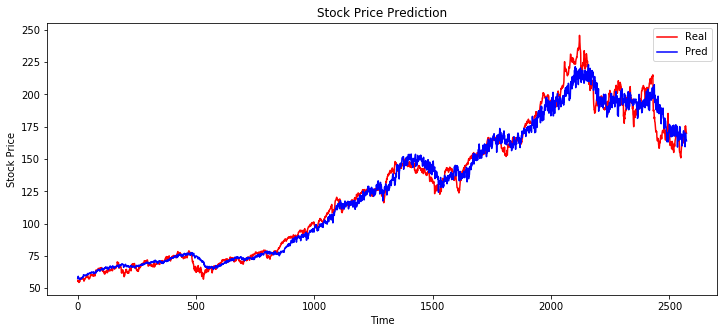

In [8]:
# Visualising the results
plt.figure(1, figsize=(12, 5))
plt.plot(real_stock_price_all, color = 'red', label = 'Real')
plt.plot(predicted_stock_price, color = 'blue', label = 'Pred')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()